<a href="https://colab.research.google.com/github/Naser-Fahad-Aldawood/Java.GUI-Hotel.System_Project/blob/main/Final_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install easyocr
!pip install imutils
!pip install pytesseract
!apt install tesseract-ocr
!pip install pytesseract opencv-python-headless
#!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 11.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from matplotlib import pyplot as plt
from numpy.ma.core import shape
from PIL import Image
import tensorflow as tf
import numpy as np
import pytesseract
import imutils
import easyocr
import cv2
import os

In [ ]:
def segment_characters(imag) :

    # Preprocess cropped license plate image
    image=cv2.imread(imag)
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

In [ ]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)

    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

1. Read in Image,Gray Scale

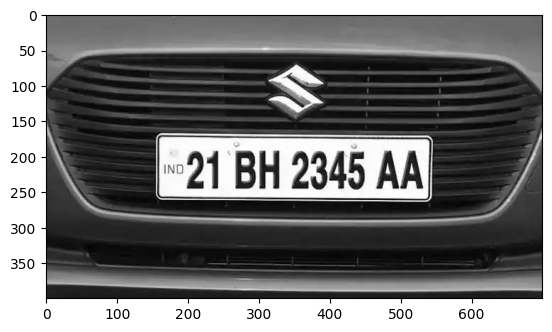

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Final Project Ramadan/Pics/IND2.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray,cv2.COLOR_BGR2RGB))


2. Apply Filter and Find edges

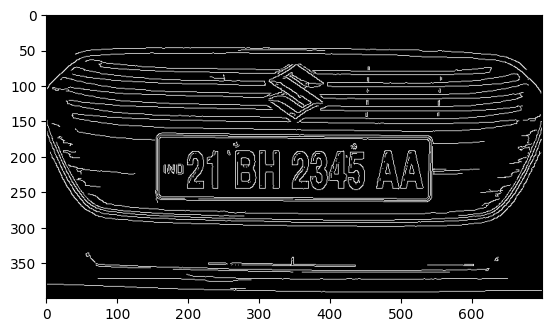

In [ ]:
bfilter1 = cv2.bilateralFilter(gray,11,17,17)#Noise Reduction

edge = cv2.Canny(bfilter1,30,200)#Edge detection
plt.imshow(cv2.cvtColor(edge,cv2.COLOR_BGR2RGB))

3. Conturs Detection apply Mask

In [ ]:
KeyPoints = cv2.findContours(edge.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
contours  = imutils.grab_contours(KeyPoints)
contours  = sorted(contours,key=cv2.contourArea,reverse=True)[:10]

In [ ]:
location = None
for contour in contours:
  approx = cv2.approxPolyDP(contour,10,True)
  if len(approx)==4:
    location = approx
    break

In [ ]:
location

array([[[159, 176]],

       [[537, 176]],

       [[539, 257]],

       [[163, 257]]], dtype=int32)

In [ ]:

mask = np.zeros(gray.shape,np.uint8)
new_image = cv2.drawContours(mask,[location],0,255,-1)
new_image = cv2.bitwise_and(img,img,mask=mask)

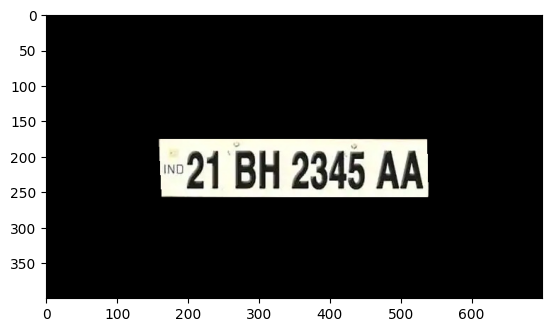

In [ ]:
plt.imshow(cv2.cvtColor(new_image,cv2.COLOR_BGR2RGB))

In [ ]:
(x,y) = np.where(mask==255)
(x1,y1)= (np.min(x) , np.min(y))
(x2,y2)= (np.max(x) , np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

In [ ]:
mdd= Image.fromarray(cropped_image)
mdd.save('cropped_image.jpg',format = 'jpeg', quality=90)

 4. **Character Segmntion**

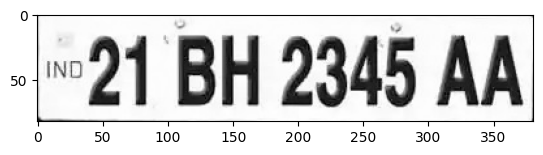

In [ ]:
plt.imshow(cv2.cvtColor(cropped_image,cv2.COLOR_BGR2RGB))

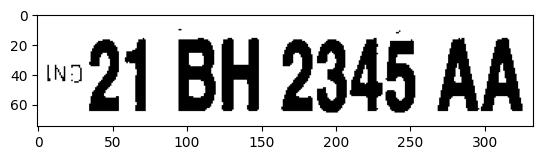

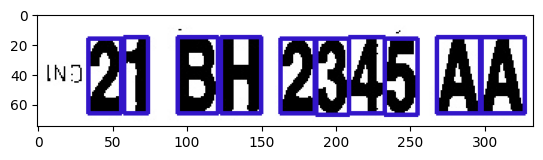

In [ ]:
char = segment_characters("/content/cropped_image.jpg")

4.1 Split each Character and Save it in single image

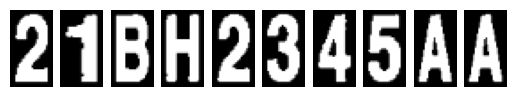

In [ ]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

5. **OCR Result**

In [ ]:
reader = easyocr.Reader(['en'])#you can add arabic but the accuracy will reduce
result = reader.readtext(cropped_image)
result

[([[2, 30], [40, 30], [40, 54], [2, 54]], 'IND', 0.8604906467989842),
 ([[28, 6], [381, 6], [381, 80], [28, 80]],
  '21 BH 2345 AA',
  0.9598094135459214)]

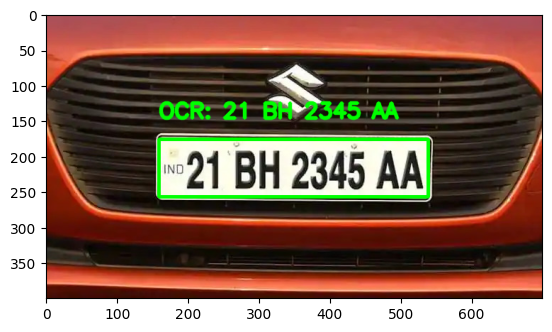

In [ ]:
text  = 'OCR: '+result[-1][-2]
#text2 = result[0]
font = cv2.FONT_HERSHEY_SIMPLEX
rse  = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]-30), fontFace=font, fontScale=1, color=(0,255,0), thickness=4, lineType=cv2.LINE_AA)
res  = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

# **CNN Section**

1. **Load data**

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/Final Project Ramadan/data w test/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/Final Project Ramadan/data w test/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

test_data=train_datagen.flow_from_directory(
        '/content/drive/MyDrive/Final Project Ramadan/data w test/test',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 108 images belonging to 36 classes.
Found 108 images belonging to 36 classes.


2. **Bulding CNN Model**

In [ ]:
model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])


3. **Train the CNN model**

In [ ]:
batch_size = 4
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator,
      validation_steps = validation_generator.samples // batch_size,
      epochs = 30 )

Epoch 1/30
  4/216 [..............................] - ETA: 4s - loss: 0.5942 - accuracy: 0.7500    

<ipython-input-44-09d75c4fa746>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


216/216 [==============================] - 6s 26ms/step - loss: 0.2901 - accuracy: 0.9120 - val_loss: 0.2018 - val_accuracy: 0.9259
Epoch 2/30
216/216 [==============================] - 7s 31ms/step - loss: 0.2712 - accuracy: 0.9259 - val_loss: 0.0220 - val_accuracy: 1.0000
Epoch 3/30
216/216 [==============================] - 8s 36ms/step - loss: 0.1932 - accuracy: 0.9213 - val_loss: 0.0106 - val_accuracy: 1.0000
Epoch 4/30
216/216 [==============================] - 6s 27ms/step - loss: 0.2594 - accuracy: 0.9120 - val_loss: 0.0386 - val_accuracy: 1.0000
Epoch 5/30
216/216 [==============================] - 7s 32ms/step - loss: 0.3714 - accuracy: 0.9167 - val_loss: 0.4963 - val_accuracy: 0.8519
Epoch 6/30
216/216 [==============================] - 7s 33ms/step - loss: 0.6189 - accuracy: 0.8704 - val_loss: 0.1648 - val_accuracy: 0.9259
Epoch 7/30
216/216 [==============================] - 6s 25ms/step - loss: 0.4148 - accuracy: 0.8704 - val_loss: 0.0262 - val_accuracy: 1.0000
Epoch 8/30

5. **Calculate The accuracy**

In [ ]:
scores = model.evaluate(test_data)
scores

108/108 [==============================] - 2s 18ms/step - loss: 0.0228 - accuracy: 1.0000


[0.022848308086395264, 1.0]

6. **CNN Result**

In [ ]:
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img

def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model.predict(img)[0] #predicting the class
        y55=y_.tolist()
        character = dic[y55.index(1)]
        output.append(character) #storing the result in a list

    plate_number = ''.join(output)

    return plate_number

plate_number = show_results()
char = char[:10]
print("Licence Plate Number:- ", plate_number)

1/1 [==============================] - 0s 28ms/step
Licence Plate Number:-  21BH2345AA


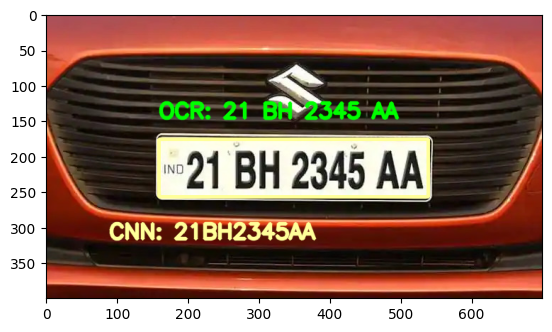

In [ ]:
text  = 'CNN: '+plate_number
#text2 = result[0]
font = cv2.FONT_HERSHEY_SIMPLEX
rse  = cv2.putText(img, text=text, org=(approx[0][0][0]-70, approx[1][0][1]+140), fontFace=font, fontScale=1, color=(153,255,255), thickness=4, lineType=cv2.LINE_AA)
res  = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (153,255,255),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))